In [0]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [0]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [0]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


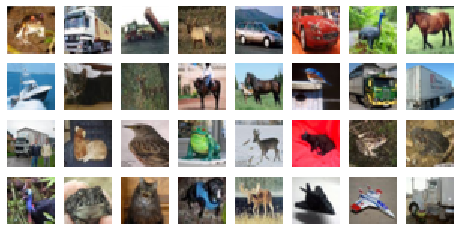

In [0]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [0]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

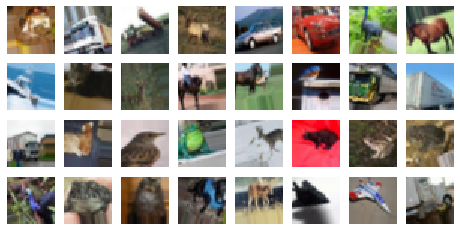

In [0]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

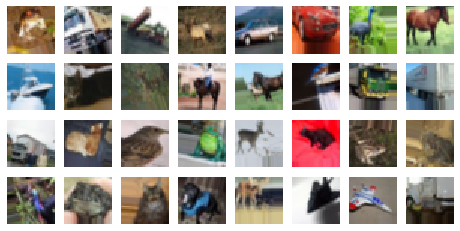

In [0]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [0]:
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers, optimizers
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import os

In [0]:
batch_size = 32
num_classes = 10
epochs = 10
img_width, img_height = 32,32


In [0]:
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_val /= 255
x_test /= 255

In [0]:
from keras import backend as K
print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

channels_last


In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))
# model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


In [0]:
!pip install keras_tqdm

In [0]:
from keras_tqdm import TQDMNotebookCallback 
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

data_generator = ImageDataGenerator(rotation_range=10,width_shift_range=0.1,height_shift_range=0.1, zoom_range=0.5)

data_generator.fit(x_train)
history = model.fit_generator(data_generator.flow(x_train,y_train, batch_size=batch_size),
                              epochs=50, validation_data=(x_val,y_val),
                              callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), earlystop])

Epoch 1/50


1250/1250 [==============================] - 25s 20ms/step - loss: 1.9054 - acc: 0.2926 - val_loss: 1.5810 - val_acc: 0.4243
Epoch 2/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.6815 - acc: 0.3854 - val_loss: 1.4449 - val_acc: 0.4756
Epoch 3/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.5756 - acc: 0.4310 - val_loss: 1.3320 - val_acc: 0.5113
Epoch 4/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.4993 - acc: 0.4583 - val_loss: 1.2563 - val_acc: 0.5409
Epoch 5/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.4512 - acc: 0.4781 - val_loss: 1.2991 - val_acc: 0.5345
Epoch 6/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.4203 - acc: 0.4964 - val_loss: 1.1814 - val_acc: 0.5689
Epoch 7/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.3857 - acc: 0.5071 - val_loss: 1.1147 - val_acc: 0.5915
Epoch 8/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.3546 - acc: 0.5186 - val_loss: 1.1093 - val_acc: 0.6034
Epoch 9/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.3377 - acc: 0.5312 - val_loss: 1.1052 - val_acc: 0.6045
Epoch 10/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.3258 - acc: 0.5318 - val_loss: 1.0737 - val_acc: 0.6174
Epoch 11/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.3006 - acc: 0.5405 - val_loss: 1.0959 - val_acc: 0.6093
Epoch 12/50


1250/1250 [==============================] - 23s 19ms/step - loss: 1.2820 - acc: 0.5504 - val_loss: 1.0204 - val_acc: 0.6406
Epoch 13/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.2610 - acc: 0.5573 - val_loss: 1.0322 - val_acc: 0.6332
Epoch 14/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.2681 - acc: 0.5568 - val_loss: 1.0016 - val_acc: 0.6374
Epoch 15/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.2472 - acc: 0.5615 - val_loss: 1.0609 - val_acc: 0.6213
Epoch 16/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.2412 - acc: 0.5654 - val_loss: 1.0244 - val_acc: 0.6401
Epoch 17/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.2340 - acc: 0.5677 - val_loss: 1.0175 - val_acc: 0.6449
Epoch 18/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.2175 - acc: 0.5738 - val_loss: 1.0228 - val_acc: 0.6349
Epoch 19/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.2168 - acc: 0.5754 - val_loss: 0.9598 - val_acc: 0.6570
Epoch 20/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.2127 - acc: 0.5761 - val_loss: 1.0439 - val_acc: 0.6269
Epoch 21/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.2037 - acc: 0.5777 - val_loss: 1.0423 - val_acc: 0.6269
Epoch 22/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.2083 - acc: 0.5757 - val_loss: 0.9390 - val_acc: 0.6614
Epoch 23/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1927 - acc: 0.5859 - val_loss: 1.0321 - val_acc: 0.6261
Epoch 24/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1929 - acc: 0.5838 - val_loss: 0.9384 - val_acc: 0.6644
Epoch 25/50


1250/1250 [==============================] - 23s 19ms/step - loss: 1.1898 - acc: 0.5832 - val_loss: 1.0005 - val_acc: 0.6414
Epoch 26/50


1250/1250 [==============================] - 23s 19ms/step - loss: 1.1831 - acc: 0.5866 - val_loss: 0.9702 - val_acc: 0.6607
Epoch 27/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1827 - acc: 0.5871 - val_loss: 0.9490 - val_acc: 0.6567
Epoch 28/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1735 - acc: 0.5894 - val_loss: 1.0482 - val_acc: 0.6436
Epoch 29/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1728 - acc: 0.5914 - val_loss: 0.9484 - val_acc: 0.6626
Epoch 30/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1678 - acc: 0.5958 - val_loss: 0.9618 - val_acc: 0.6617
Epoch 31/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1672 - acc: 0.5946 - val_loss: 0.9032 - val_acc: 0.6838
Epoch 32/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1647 - acc: 0.5906 - val_loss: 0.9849 - val_acc: 0.6435
Epoch 33/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1588 - acc: 0.5964 - val_loss: 0.9909 - val_acc: 0.6444
Epoch 34/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1541 - acc: 0.5981 - val_loss: 0.9210 - val_acc: 0.6727
Epoch 35/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1539 - acc: 0.5961 - val_loss: 0.9215 - val_acc: 0.6771
Epoch 36/50


1250/1250 [==============================] - 23s 19ms/step - loss: 1.1497 - acc: 0.6002 - val_loss: 0.9768 - val_acc: 0.6612
Epoch 37/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1533 - acc: 0.5998 - val_loss: 0.9126 - val_acc: 0.6652
Epoch 38/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1537 - acc: 0.5986 - val_loss: 0.8788 - val_acc: 0.6869
Epoch 39/50


1250/1250 [==============================] - 23s 19ms/step - loss: 1.1436 - acc: 0.6005 - val_loss: 0.9303 - val_acc: 0.6731
Epoch 40/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1517 - acc: 0.5996 - val_loss: 0.8935 - val_acc: 0.6920
Epoch 41/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1368 - acc: 0.6030 - val_loss: 0.9122 - val_acc: 0.6815
Epoch 42/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1451 - acc: 0.6022 - val_loss: 0.8794 - val_acc: 0.6874
Epoch 43/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1328 - acc: 0.6062 - val_loss: 0.9185 - val_acc: 0.6781
Epoch 44/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1285 - acc: 0.6082 - val_loss: 0.9236 - val_acc: 0.6675
Epoch 45/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1331 - acc: 0.6082 - val_loss: 0.8927 - val_acc: 0.6798
Epoch 46/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1315 - acc: 0.6082 - val_loss: 0.9184 - val_acc: 0.6739
Epoch 47/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1349 - acc: 0.6080 - val_loss: 0.9487 - val_acc: 0.6611
Epoch 48/50


1250/1250 [==============================] - 23s 18ms/step - loss: 1.1300 - acc: 0.6097 - val_loss: 0.8915 - val_acc: 0.6943
Epoch 00048: early stopping


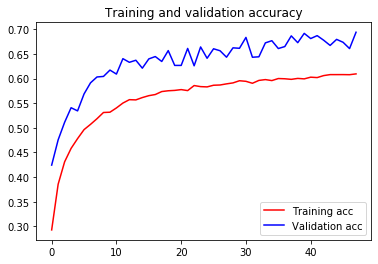

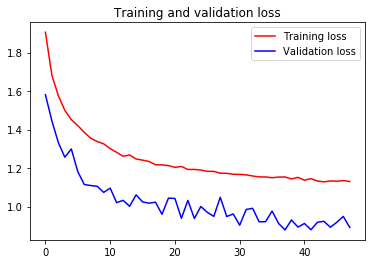

In [0]:
# 畫訓練過程中準確率跟loss的曲線
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# result = list(np.argmax(model.predict_generator(data_generator.flow(x_test, y_test, batch_size=batch_size)), axis=1))
result = model.predict_classes(x_test)
len(result)
result[0], np.argmax(y_test[0])

(3, 3)

In [0]:
mask = result == np.argmax(y_test)
correct = np.count_nonzero(mask)
print(f'correct:{correct}, {correct*100.0/len(y_test)}')

correct:1180, 11.8


In [0]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 73us/step
Test loss: 0.9132210915565491
Test accuracy: 0.6816


In [0]:
train_generator = data_generator.flow(x_train, y_train, batch_size=batch_size)
valid_generator =data_generator.flow(x_val, y_val, batch_size=batch_size)

In [0]:
from keras_tqdm import TQDMNotebookCallback 
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5,
                    callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), earlystop],
                    verbose=1)

Epoch 1/5


1250/1250 [==============================] - 26s 21ms/step - loss: 1.6948 - acc: 0.3751 - val_loss: 1.3381 - val_acc: 0.5115
Epoch 2/5


1250/1250 [==============================] - 25s 20ms/step - loss: 1.3559 - acc: 0.5115 - val_loss: 1.1860 - val_acc: 0.5737
Epoch 3/5


1250/1250 [==============================] - 25s 20ms/step - loss: 1.2305 - acc: 0.5598 - val_loss: 1.0991 - val_acc: 0.6063
Epoch 4/5


1250/1250 [==============================] - 25s 20ms/step - loss: 1.1556 - acc: 0.5887 - val_loss: 1.0320 - val_acc: 0.6298
Epoch 5/5


1250/1250 [==============================] - 25s 20ms/step - loss: 1.0951 - acc: 0.6118 - val_loss: 1.0172 - val_acc: 0.6413
